# AM207 Final Project
# Practical Bayesian Optimization of Machine Learning Algorithms

**Keywords: Bayesian Optimization, Gaussian Process, Acquisition Functions**

**Collaborators: Yukun Xia, Lechen Qian, Junhan Gu**

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm

import pandas as pd
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn")

import pymc3 as pm

import scipy.stats
import scipy.special
from scipy.optimize import minimize,basinhopping
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Tuning model hyperparameters, regularization terms and optimization parameters can be a black art for machine learning. In this project we explained how to develop an automatic tuning method by applying **Bayesian Optimization** and wrote the code to test the Bayesian Optimization method. We first test the theorectical reasoning of the paper using two and then apply it to MNIST dataset with neural network model to tune learning rate and regularization terms.<br/>

Paper URL: https://arxiv.org/abs/1206.2944

## Why Bayesian Optimization?

The difficulty of tuning hyperparameters in different machine learning methods led many researchers to explore different methods for hyperparameter tuning, because we cannot apply the first- and second-order methods like gradient descent, Newton’s method, or quasiNewton to the black-box objective function. Currently, basic hyperparameter tuning method includes **grid search**, **random search** or **grad student** search. However, as for the grid search, the exhaustive sampling of the hyperparameter space can be computationally expensive and quite inefficient -- the process takes many time-consuming training cycles, but still does not guarantee the best hyperparameters for the model. Random search assumes that not all the hyperparameters are equally important and focuses more on finding the optimal value for the important hyperparameter.

In this tutorial we introduce **Bayesian optimization**, a class of global optimization methods where we want to find the minimum (or maximum) of a black-box function $f(x)$ on some bounded set $\chi$. It is a type of sequential model-based optimization (SMBO) algorithms, and unlike grid search or random search, we use the results of our previous iteration to improve our sampling method of the next experiment. 

Bayesian optimization requires us to select a prior (here we choose Gaussian Process prior) and construct a probabilistic model for the objective function, then choose an acquisition function for determining the next point to sample, where we calculate the utility function from the posterior. In the following two sections we are going to introduce the **Gaussian Process** and **acquisition functions**.

## Gaussian Process

According to the definition in Wikipedia, a Gaussian process is a stochastic process, in which a collection of random variables drawn from a multivariate normal distribution indexed by time or space. The distribution over functions has a continuous domain, e.g. time or space, as Gaussian process is a joint distribution of all the random variables. 
Define some space:
Input space: $\chi$ <br/>
model scalar function:$f:\chi \to \mathbb{R}$ <br/>
Positive definite covariance function: $C:\chi \times \chi\to \mathbb{R}$<br/>
mean function: $m:\chi \to \mathbb{R}$
From what we learned on class, assume we have this function vector $f=(f(x_1),…f(x_n))$, for any choice of input points, $(x_1,…,x_n)$, the marginal distribution over $f$:

$P(F)=\int f_{f\in F}P(f)df$, is multi-variate Gaussian. Then the distribution $P(f)$ over the function $f$ is said to be a Gaussian Process.

We write a Gaussian Process thus:

$f(x)∼GP(m(x),k(x,x′))$
where the mean and covariance functions can be thought of as the infinite dimensional mean vector and covariance matrix respectively. <br/>

The figures below illustrates how we fit a GP.

<img src="images/WechatIMG2.jpeg" alt="Drawing" style="width: 400px;"/>

<img src="images/WechatIMG3.png" alt="Drawing" style="width: 400px;"/>

<img src="images/WechatIMG4.png" alt="Drawing" style="width: 400px;"/>

![](images/WechatIMG3.jpeg)

## Kernel Function and Examples of GP covariance

The learning algorithm using a Gaussian process uses a measure of the similarity between points (the kernel function) to predict the value for unseen points from the existing dataset. In the prediction, we'll not only have the information of an estimate of mean value for that point, but also has uncertainty information. These information derives from the marginal distribution at that point, which is a one-dimensional Gaussian distribution, by marginalizing over the many variables that we are not interested in.

ARD squared exponential kernel:
$$K_{SE}(\mathbf{x},\mathbf{x}') = \theta_0 exp\{-\frac{1}{2}r^2(\mathbf{x},\mathbf{x}')\}$$
where $r^2(\mathbf{x},\mathbf{x}')=\sum_{d=1}^D(x_d-x_d')^2/\theta_d^2$

In the paper the author recommended ARD Matern 5/2 kernel, which is twice differentiable but does not require the smoothness of the squared exponential.
$$K_{M52}(\mathbf{x},\mathbf{x}') = \theta_0\left(1+\sqrt(5r^2(\mathbf{x},\mathbf{x}')+\frac{5}{3}r^2(\mathbf{x},\mathbf{x}')\right)exp\left\{-\sqrt{5r^2(\mathbf{x},\mathbf{x}')}\right\}$$

## Uncertainty in Optimization

During the optimization process, the goal of each update is to find the minimum: $x^* = arg min_{x \in \chi} f(x)$. GP gives us easy closed-form of marginal means and variance. For searching the next minimum, we can do more exploration on places with high variance, but also can do more exploitation by seeking places with low means.
The acquisition functions provide a way to balance the exploration and exploitation to determine the next point to evaluate.

## Acquisition Function

We can solve the aforementioned tradeoff of **exploitation** (the mean is low) and **exploration** (the variance is high) with the **acquisition function**.The prior and existing datapoints induce a posterior over functions: the acquisition function, and the goal is the evaluate the points and move to the point which maximize the acquisition function. Several different functions have been proposed. We evaluated all three aqcuisition funstion proposed by author and recommend Expected Improvement. <br/>

**Denotation:**<br/>
Acquisition functions depend on the previous observations and GP hyperparameters: $a(x ; \{x_n, y_n\}, \theta)$. <br/>
Under the Gaussian process prior, these acquisition functions depend on the model solely through its predictive mean function $\mu(x ; \{x_n, y_n\}, \theta)$ and predictive variance function $\sigma^2(x ; \{x_n, y_n\}, \theta)$<br/> 
$\Phi(·)$ will denote the cumulative distribution function of the standard normal.<br/>
$x_b$ denote the point which has current best value.

Authors proposed three types of acquisition function in the paper:<br /> 
(1) **Probability of Improvement `PI`**. The rationale of this strategy is to maximize the probability of improving over the best current value (Kushner, 1964), by integrating the pdf of marginal normal distribution from minus infinity to the point($x_b$) where resides the best current value. Under the GP this has closed form:
$$a_{PI}(x ; \{x_n, y_n\}, \theta) = \Phi(\gamma(x))$$
$$ \gamma(x) = \frac{f(x_{b}) − \mu(x ; \{xn, yn\}, \theta)}{\sigma(x ; \{x_n, y_n\}, \theta)}$$<br /> 

However, we employed this strategy in acquisition function to evaluate points, end up realizing it's quite unstable and inefficient in finding global minimum. The process of minizing the acquisition function will be stuck at saddle points, where nearly zero gradient disables the algorithm to descend. <br/>

(2) **GP Lower Confidence Bound `LCB`**. Based on this idea, we are supposed to harness the lower confidence bounds (upper, when considering maximize the value of the acquisition function) to find the next point with lowest value. The acquisition functions have this following analytical form
$$a_{LCB}(x ; \{x_n, y_n\}, \theta) = \mu(x ; \{x_n, y_n\}, θ\theta) − \kappa \sigma(x ; \{x_n, y_n\}, \theta)$$,
with a tunable $\kappa$ to balance exploitation against exploration.<br />

After our test, this acquisition function can facilitate the model to perform well.<br/>

(3) **Expected Improvement `EI`**. This acquisition function was selected by authors of the paper by maximizing the expected improvement (EI) over the current best, and they claim that this could be better-behaved than probability of improvement, and not require one more tuning parameter $\kappa$ in LCB. The closed form under the Gaussian process:
$$a_{EI}(x ; \{x_n, y_n\}, \theta) = \sigma(x ; \{x_n, y_n\}, \theta) (\gamma(x) \Phi(\gamma(x)) + \mathcal{N} (\gamma(x) ; 0, 1))$$

We show the derivation of the formula as follows:

$$
\begin{align}
a_{EI}(x ; {x_n, y_n}, \theta)  &=\int_{-\infty}^{f(x_b)}[f(x_b)-f(x)] p(f(x))dx\\
& = f(x_b)\int_{-\infty}^{f(x_b)}p(f(x))dx - \int_{-\infty}^{f(x_b)}f(x)p(f(x))dx\\
\end{align}
$$

Denote the left part as $LP$ and the right part as $RP$, then look at seperately:

LP term：
$$
\begin{align}
&f(x_b) = \sigma(x;\{x_n, y_n\}, \theta)\gamma(x)+\mu(x;\{x_n, y_n\}, \theta)\\
&\int_{-\infty}^{f(x_b)}f(x)p(f(x))dx = \Phi(\gamma(x))\\
&\therefore  LP = \sigma(x;\{x_n, y_n\}, \theta)\gamma(x)\Phi(\gamma(x))+\mu(x;\{x_n, y_n\}, \theta)\Phi(\gamma(x))\\
\end{align}
$$
RP term：$\sigma(x;\{x_n, y_n\},\theta)$ as $\sigma$, $\mu(x;\{x_n, y_n\},\theta)$ as $\mu$
$$
\begin{align}
&f(x) p(f(x) = \frac{f(x)}{\sqrt{2\pi\sigma^2}}e^{-\frac{(f(x)-\mu)^2}{2\sigma^2}})\\
&\therefore RP = \int_{-\infty}^{f(x_b)}f(x)p(f(x))dx = -\frac{\sigma}{\sqrt{2\pi}}e^{-\frac{(f(x)-\mu)^2}{\sqrt{2\sigma^2}}}+\mu\Phi(\gamma(x))\\
\end{align} 
$$
Then we'll have
$$
\begin{align}
LP-RP &=\sigma(x;\{x_n, y_n\}, \theta)\gamma(x)\Phi(\gamma(x))+\mu(x;\{x_n, y_n\}, \theta)\Phi(\gamma(x))+\frac{\sigma}{\sqrt{2\pi}}e^{-\frac{(f(x)-\mu(x))^2}{\sqrt{2\sigma^2}}}\\
&=\sigma(x;\{x_n, y_n\}, \theta)\gamma(x)\Phi(\gamma(x))+\mu(x;\{x_n, y_n\}, \theta)\Phi(\gamma(x))+\mathcal{N}(\gamma(x);0,1) \\
& = \sigma(x)[\gamma(x)\Phi(\gamma(x))+\mathcal{N}(\gamma(x);0,1)]
\end{align} 
$$

$$
\therefore a_{EI} = \sigma(x;\{x_n, y_n\}, \theta)[\gamma(x)\Phi(\gamma(x))+\mathcal{N}(\gamma(x);0,1)]
$$

<img src="images/WechatIMG5.jpeg" alt="Drawing" style="width: 400px;"/>

<img src="images/WechatIMG6.jpeg" alt="Drawing" style="width: 400px;"/>

The above two figures explain how the acquisition function works. We fit a GP using the existing data points to get a model for the function. We plot the acquisition function at the bottom of the plot and find the $x^*$ that maximize the acquisition function as the next point to sample, which reduce the uncertainty (sample the places with highest variance) and exploit the range with lowest mean. We keep sampling until we find the optimum.

## Coding Time!

Based on the idea of this paper, we coded the Bayesian Optimization method `BayeOpt` to implement practical Bayesian optimization. `pymc3` and `scipy.optimize` are utilized for sampling and optimization in the model.<br/>

We first provide an intuitive intepretation: We initialize our model with hyperparameters $\lambda$, and score $v$ to it after training. Next, we use the previously evaluated hyperparameter values to compute a posterior expectation of the hyperparameter space. We can then choose the optimal hyperparameter values according to this posterior expectation as our next model candidate. We iteratively repeat this process until converging to an optimum. 

The algorithm can be written as below.

> **Bayesian Optimization Algorithm `BayeOpt`**
1. for t=1,2,... do
2. Find $x_t$ by combining attributes of the posterior distribution in an acquisition function u and maximize
$$x_t = argmax_x a(x|\mathcal{D})$$
3. Sample the objective function
4. Augment the data $\mathcal{D}_{1:t} = \{\mathcal{D}_{1:t-1},(x_t,y_t)\}$ and again fit the GP.
5. end for

In the following part, we'll quickly walk through our model and code.<br/>

The `target_func` is the function that we want to optimize by the method introduced in this paper. `x_range` is the range of domain of traget function. Gaussian process would require several points for initialization. In our model, the defalt setting of initial `x` points are the x value of two ends of the domian and the point lying in the middle. Additional inital points can be added by giving value to parameter init_points, e.g., init_points = 3 means three extra initiation points will be included, which would probably lead to better performance of the optimization process.<br/> 

Kernel function `kernel`, in another word, covariance function is crucial for Gaussian process to represent a large repotoire of distributions of function. A common practice is that people use the automatic relevance determination (ARD) squared exponential kernel for Gaussian process regression. However, the concern is that sample functions with this covariance function are too smooth for real world optimization problems. As suggested by the author of this paper, we'll choose Matern52 as our kernel, which is twice differentiable. The rationale behind this is this kernel can make sample functions corresponds to those made by quasi-Newton methods, and more close to real-world situation.

Hyperparameters in Gaussian Process. We need to distinguish the hyperparameters subjected to the overall Bayesian optimization and the hyperparameter we set for Gaussian process, which govern its behavior. For $D$ dimension space of target function, we would have $D + 3$ Gaussian process hyperparameters: $D$ length scales $\theta$, the covariance amplitude $\theta_0$, the observation noise $ν$, and a constant mean $m$. We tested several prior distribution of $\theta_0$ and $\theta$, including **Half-Cauthy, Gamma, exponantial**. 

We found sampling a point close to one will lead to error in the model, we seek to use Gamma as prior distribution since give less chance to sample a point near zero, in comparison with Half-Cauchy distribution. As tested, Half-Cauchy gives extremely unstable performance and failed the task frequently, we prefer to use Gamma distribution as prior for $\theta_0$ and $\theta$， with the merits that it rectifies itself before going to far in the wrong direction. And the initiation strategy for prior distribution is $\nu=1$,$theta_0=1$,$theta_1=1$.<br/>


Optimization method and its corresponding acquisition function can be specified in the function `Sampling.Sampling(self,mode,acquisition)`<br/>
Choises for mode: <br/>
`Opt` represent optimization, which is a common approach by leveraging a point estimate of these parameters through optimizing the marginal likelihood under the Gaussian process and find the MAP. It mathmatical expression is as follows:$$P(y|\{x_n\}_{n=1}^N, \theta, v, m) = \mathcal{N}(\mathbf{y}|m\mathbf{1}+\mathbf{\Sigma}_\theta+v\mathbf{I})$$,where $Σ\theta$ is the covariance matrix resulting from the N input points under the hyperparameters $\theta$.<br/>

`MCMC` represent a sampling method by Markov Chain Monte Carlo. N samples will be drawed by a GP model we developed on pymc3. <br/>

Using subfunction `acq(x_star)`, where `x_star` represent a vector of points, we can evaluate these points by applying one of the learning policy of acquisition function: PI, EI or LCB. From there, we'll choose the point of minimal value to become the next point, which will be implemented by subfunction `Get_next`.<br/>

function `Iteration` is a main function which incoparate these subfunction to implement the bayesian optimization task. Everytime, among all the new pool of points being evaluated, the point with best maximal acquisition value will be taken and incorparate into existing datapoints. Max number of iterations can be set and the algorithm will automatically stop optimizing when the step of a move towards a new point is strictly smaller then the 0.01% of the range of the domain. To prevent the algorithm from getting trapped in the local minimum or saddle point, "x new is old!" warning message will appear and the optimization process stops when the next point choose by the algorithm remain unaltered from the previous one.<br/>

For simple yet elegant demonstration, we choose two functions $g(x)=x^2$ and $f(x,y)=x^2+y^2$ as target function, and evaluate the performance of our algorithm. Since these two functions have global minima at 0 for $g$ and (0,0) for $f$, and the curve are idealy smooth, we expect to see the output of the algorithm will converge to these points, with sufficiently small noise close to 0.

In [15]:
class BayeOpt():
    def __init__(self,target_func,x_range,kernel = "Gaussian",init_points=3,render=True): # replace Gaussian with Matern52 later
        self.target_func = target_func
        self.cov_func = kernel
        
        self.x_min = np.array(x_range[0]).reshape(-1,) # assume x y are all continuous first
        self.x_max = np.array(x_range[1]).reshape(-1,) # x_min and max 's shape == (self.dim,1)
        self.x_mid = 0.5*self.x_min + 0.5*self.x_max
        self.x = np.vstack((self.x_min,self.x_mid,self.x_max))
        self.dim = self.x_min.size
        for i in range(max(init_points-3,0)):
            x_sample = []
            for d in range(self.dim):
                a = np.random.rand()
                x_sample.append(a*self.x_min[d] + (1-a)*self.x_max[d])
            x_sample = np.array(x_sample).reshape(1,-1)
            self.x = np.vstack((self.x,x_sample))
        print(self.x)
        self.y = np.array([target_func(t) for t in self.x]).reshape(-1,)
        self.x_range = np.linalg.norm(self.x_min-self.x_max)
        self.prior = {'nu': 1,'theta0': 1,'theta': 1,'alpha': 1,"beta": 1\
                     ,"alpha0": 1,"beta0": 1} # add some initialization strategy, theta for D length scale theta1:D
        self.render=render
    
    def Sampling(self,mode = "OPT",acquisition = "EI"):
        print("\n-----------------------------------------------\n")
        with pm.Model() as model:
            theta = pm.Gamma("theta",alpha=self.prior['alpha'],beta=self.prior['beta'],shape = (self.dim,))
            theta0 = pm.Gamma("theta0",alpha=self.prior['alpha0'],beta=self.prior['beta0']) 
            if self.cov_func == "Matern52":
                cov_func = theta0**2 * pm.gp.cov.Matern52(input_dim = self.dim,ls = theta)
            elif self.cov_func == "Gaussian":
                cov_func = theta0**2 * pm.gp.cov.ExpQuad(input_dim = self.dim,ls = theta)
            # add more covariance functions here later
            else:
                raise ValueError("No such covariance function in library")
            m = pm.gp.mean.Constant(self.y.mean())
            gp = pm.gp.Marginal(m,cov_func)
            nu = pm.HalfCauchy("nu",self.prior['nu']) # noise.
            gp.marginal_likelihood("f", X=self.x, y=self.y, noise=nu)
#             print("x y list:",self.x,self.y)
            
            if mode == "MCMC":
                trace = pm.sample(1000,chains=1)
                pm.traceplot(trace);
                x_next_ls = []
                for t in trace[::250]: # Remove this thinning later
                    x_next_ls.append(self.Get_next(params=t,acquisition=acquisition,gp=gp))
                x_next = np.array(x_next_ls).mean(axis=0)
                return x_next
            elif mode == "OPT":
                MAP = pm.find_MAP()
#                 print("MAP:",MAP)
                x_next = self.Get_next(params=MAP,acquisition=acquisition,gp=gp)
                return x_next
    
    def Get_next(self,params,acquisition,gp):
        # define acqusition function
        def acq(x_star):
            x_star = np.array(x_star).reshape(1,-1)
            mean,var = gp.predict(x_star,point=params,diag=True,pred_noise=False)
#             print("\nmean,var:",mean,var)
            mean = mean[0]
            std = np.sqrt(var[0])
            if acquisition == "EI":
                f_best = self.y.min()
                gamma = (-f_best+mean)/std
                return std*(norm.cdf(gamma)*gamma+norm.pdf(gamma))
            elif acquisition == "PI":
                f_best = self.y.min()
                gamma = (-f_best+mean)/std
                return norm.cdf(gamma)
            elif acquisition == "LCB":
                return mean-2*std
                
        # optimize
        bounds = [(low, high) for low, high in zip(self.x_min, self.x_max)]
        result = minimize(acq,x0=self.x_mid,bounds=bounds)
        x_next = result.x
        print("grad:",result.jac)
        print("x_next:",x_next)
        if self.render == True:
            self.Render(self.target_func,x_next)
        return x_next
    
    
    def Iteration(self,x_existing = None,y_existing = None, mode = "MCMC",acquisition = "EI",max_iter = 10):
        if x_existing != None and y_existing != None:
            self.x = x_existing
            self.y = y_existing
        for i in range(max_iter):
            x_new = self.Sampling(acquisition = acquisition,mode = mode)
            if x_new in self.x:
#                 print("x new is old!")
                break
#             print("\nx new:",x_new)
            y_new = self.target_func(x_new)
#             print('\ny new:',y_new)
            self.x = np.vstack((self.x,x_new))
            self.y = np.hstack((self.y,y_new))
#             if i > 0 and np.linalg.norm(x_new-self.x[-2])*10000 < self.x_range:
#                 break
        return self.x[np.argmin(self.y)]
    
    
    def Render(self,func,point):
        x = np.linspace(self.x_min,self.x_max,20)
        y = func(x)
        plt.figure(figsize=(3,3))
        plt.xlim(self.x_min,self.x_max)
        plt.plot(x,y,c="k",label="unknown target function")
        plt.scatter(self.x, self.y, marker='o', color="b",label="existing")
        plt.plot([point], [func(point)], marker='o', markersize=10, color="red",label="next one")
        plt.legend(loc="best")
        plt.show()

---
1D example: This is an demonstration of Bayesian optimization for hyperbolic function.
In addition to three initial points we pre-defined for each optimization process, here `init_point` = 3 means we'll introduce three more initial points.

We run our model on the following combinations:<br/>
GP OPT LCB:mode = "OPT",acquisition = "LCB"<br/>
GP OPT EI:mode = "OPT",acquisition = "EI"<br/>
GP MCMC LCB:mode = "MCMC",acquisition = "LCB"<br/>
GP MCMC EI:mode = "MCMC",acquisition = "EI"<br/>
and compare the performances<br/>

In [3]:
# give a simple function g(x) = x^2
g = lambda x:x**2
g_range = [-5,2]

***GP OPT LCB***

In [4]:
baye_1d_GP_OPT_LCB = BayeOpt(target_func=g,x_range=g_range,init_points=6)


-----------------------------------------------



/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]`

grad: [0.00083817]
x_next: [0.03304504]


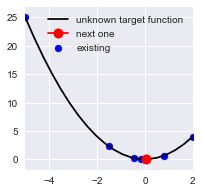


-----------------------------------------------



/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -20.899, ||grad|| = 8.9659: 100%|██████████| 21/21 [00:00<00:00, 715.01it/s]  


grad: [0.00147398]
x_next: [0.01112515]


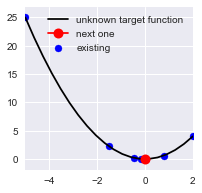


-----------------------------------------------



logp = -10.646, ||grad|| = 0.0097434: 100%|██████████| 69/69 [00:00<00:00, 706.32it/s]  


grad: [-0.00053528]
x_next: [0.00623642]


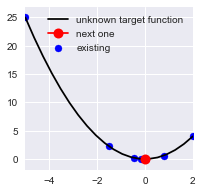


-----------------------------------------------



logp = -19.095, ||grad|| = 18.531: 100%|██████████| 14/14 [00:00<00:00, 685.97it/s]  


grad: [-0.00226754]
x_next: [0.00630234]


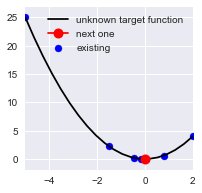




-----------------------------------------------



best result is  [0.00623642]


In [6]:
best_result = baye_1d_GP_OPT_LCB.Iteration(mode = "OPT",acquisition = "LCB",max_iter = 7)
print("\n\n\n-----------------------------------------------\n\n\n")
print("best result is ",best_result)

***GP OPT EI***


-----------------------------------------------



logp = -25.905, ||grad|| = 0.00084997: 100%|██████████| 37/37 [00:00<00:00, 752.54it/s]  


grad: [5.54554321e-06]
x_next: [-0.12101218]


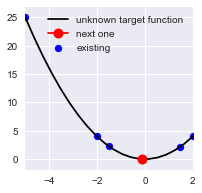


-----------------------------------------------



logp = -21.935, ||grad|| = 0.072175: 100%|██████████| 24/24 [00:00<00:00, 600.39it/s]  


grad: [3.03258266e-06]
x_next: [-0.0593042]


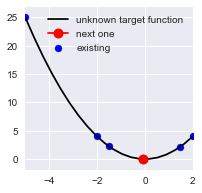


-----------------------------------------------



logp = -14.474, ||grad|| = 0.0072823: 100%|██████████| 89/89 [00:00<00:00, 873.29it/s]  


grad: [7.69232666e-06]
x_next: [-0.01790419]


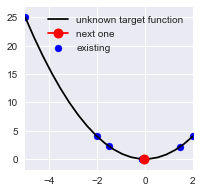


-----------------------------------------------



logp = -2.8331, ||grad|| = 0.37472: 100%|██████████| 98/98 [00:00<00:00, 601.37it/s]  


grad: [-3.94461902e-05]
x_next: [-0.0029436]


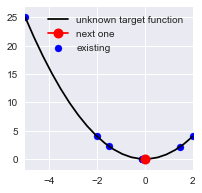


-----------------------------------------------



logp = -inf, ||grad|| = 0: 100%|██████████| 12/12 [00:00<00:00, 609.32it/s]  


grad: [-7.53231022e-06]
x_next: [-0.00246203]


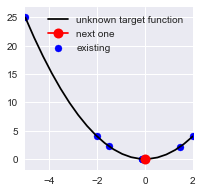




-----------------------------------------------



best result is  [-0.00246203]


In [7]:
baye_1d_GP_OPT_EI = BayeOpt(target_func=g,x_range=g_range,init_points=6)
best_result = baye_1d_GP_OPT_EI.Iteration(mode = "OPT",acquisition = "EI",max_iter = 7)
print("\n\n\n-----------------------------------------------\n\n\n")
print("best result is ",best_result)

***GP MCMC LCB***


-----------------------------------------------



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:14<00:00, 104.24it/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


grad: [3.55271368e-07]
x_next: [-0.92802699]


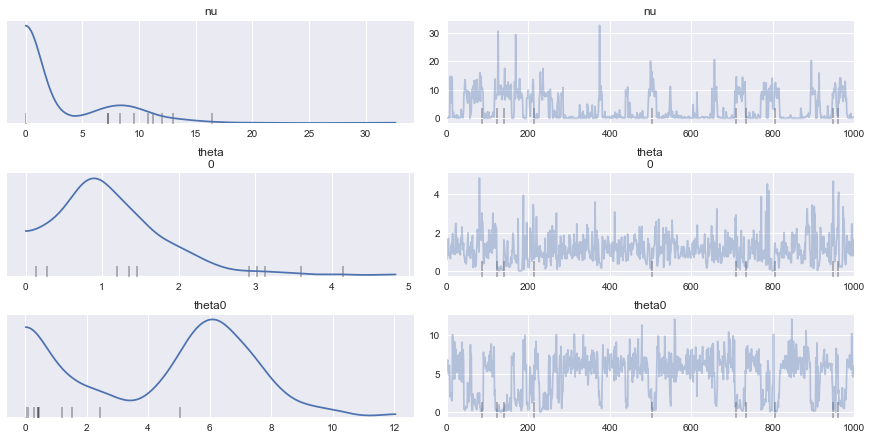

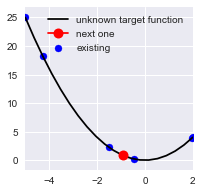

grad: [1.77635684e-07]
x_next: [-0.9236516]


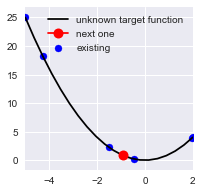

grad: [0.]
x_next: [-1.5]


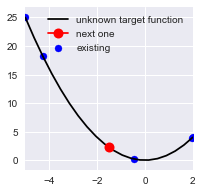

grad: [1.77635684e-07]
x_next: [-0.84881271]


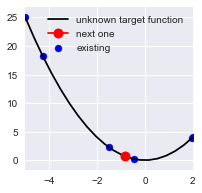


-----------------------------------------------



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:06<00:00, 230.43it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


grad: [4.57411886e-06]
x_next: [0.25922714]


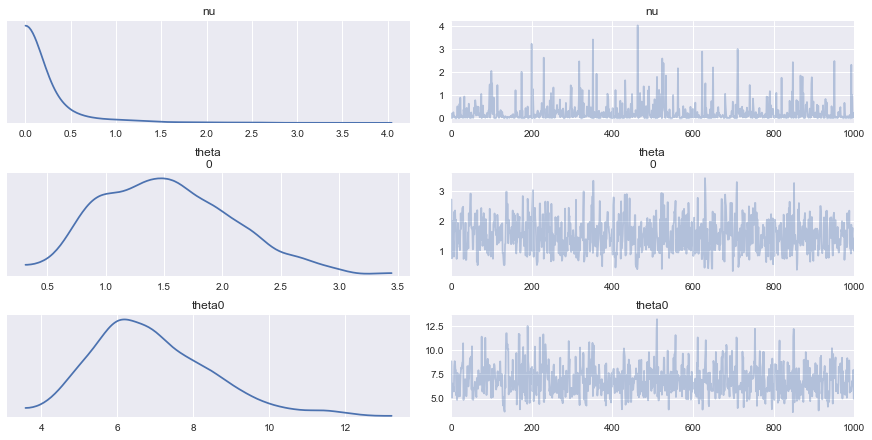

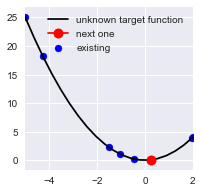

grad: [9.76996262e-06]
x_next: [0.48765599]


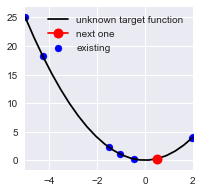

grad: [5.32907052e-07]
x_next: [0.67370885]


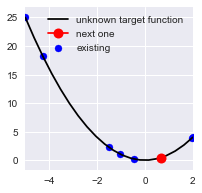

grad: [-7.10542736e-07]
x_next: [0.49274322]


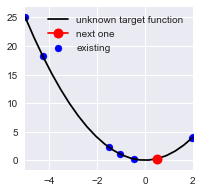


-----------------------------------------------



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:07<00:00, 188.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


grad: [4.40758541e-06]
x_next: [0.0397819]


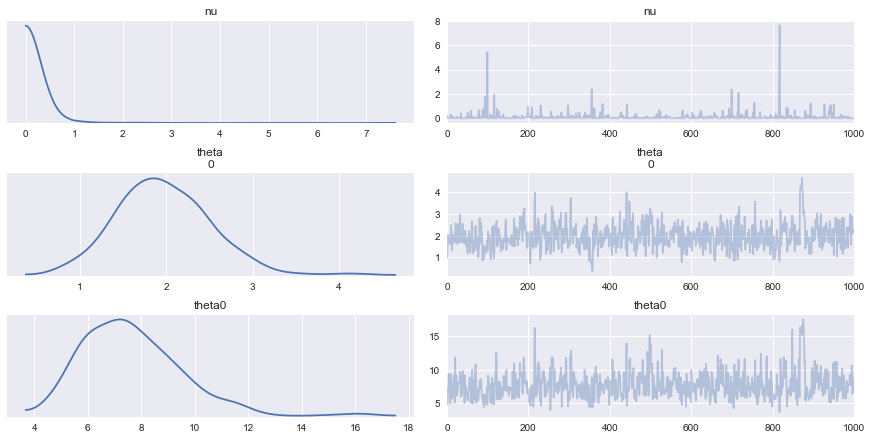

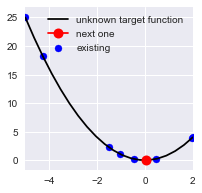

grad: [2.0181079e-05]
x_next: [-0.00913372]


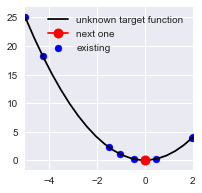

grad: [0.00446975]
x_next: [-9.19061215e-05]


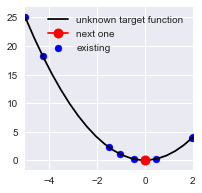

grad: [-7.00273173e-06]
x_next: [-0.01563164]


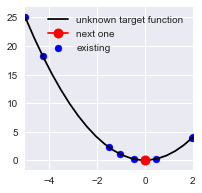


-----------------------------------------------



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:07<00:00, 197.85it/s]
The acceptance probability does not match the target. It is 0.8830550775551569, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


grad: [0.00047445]
x_next: [-0.00076816]


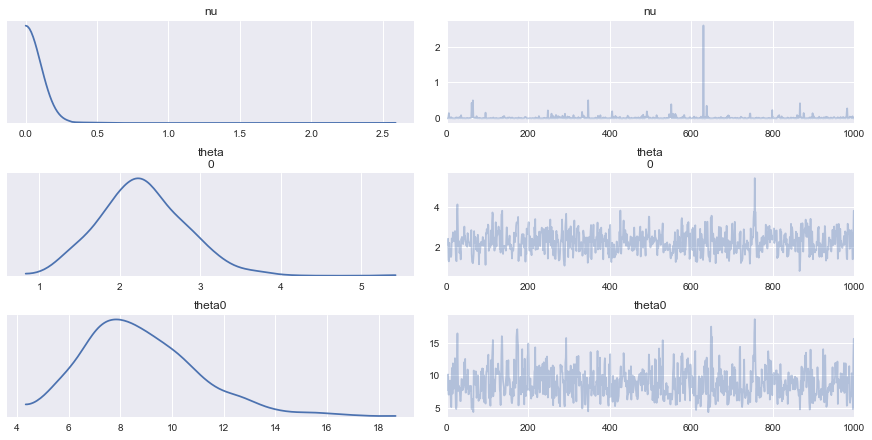

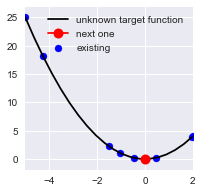

grad: [-0.00012348]
x_next: [-0.00095034]


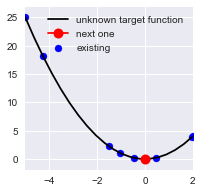

grad: [0.00016388]
x_next: [0.00196238]


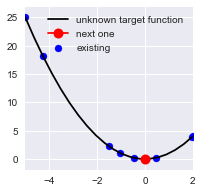

grad: [-3.36503395e-05]
x_next: [-0.00082988]


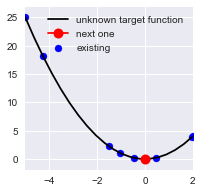


-----------------------------------------------



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:07<00:00, 190.79it/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


grad: [0.00305858]
x_next: [0.00034587]


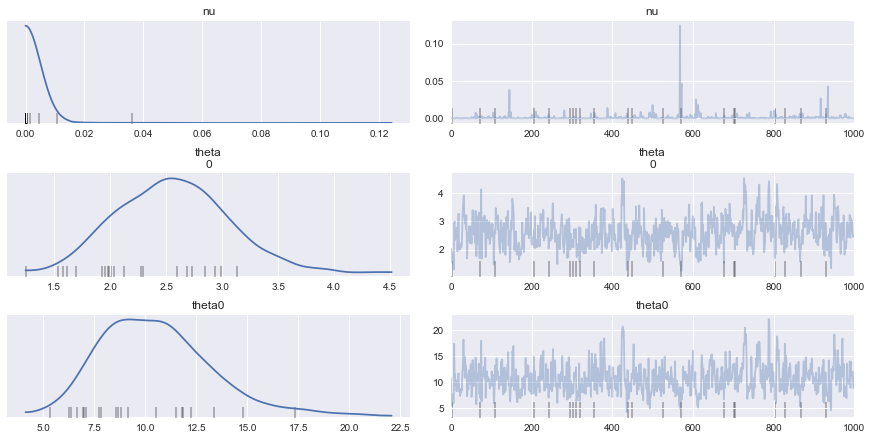

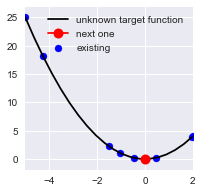

grad: [-0.00208297]
x_next: [0.00018853]


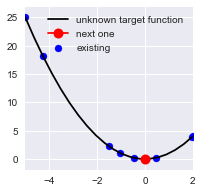

grad: [0.00124919]
x_next: [-0.00258145]


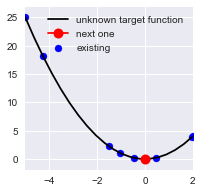

grad: [-0.00113905]
x_next: [0.00095879]


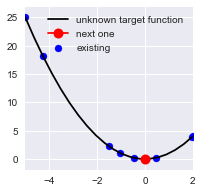




-----------------------------------------------



best result is  [-0.0001465]


In [9]:
baye_1d_GP_MCMC_LCB = BayeOpt(target_func=g,x_range=g_range,init_points=6)
best_result = baye_1d_GP_MCMC_LCB.Iteration(mode = "MCMC",acquisition = "LCB",max_iter = 7)
print("\n\n\n-----------------------------------------------\n\n\n")
print("best result is ",best_result)

***GP MCMC EI***


-----------------------------------------------



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:12<00:00, 117.55it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


grad: [0.]
x_next: [0.18991281]


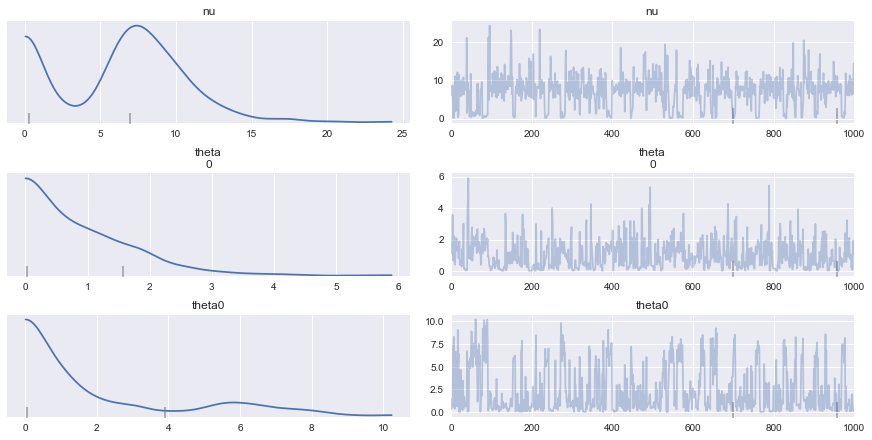

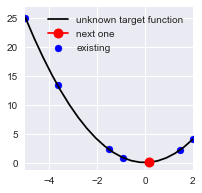

grad: [1.77635684e-07]
x_next: [-1.49090772]


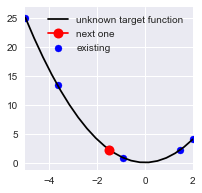

grad: [0.]
x_next: [-1.04244515]


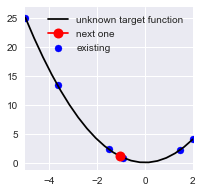

grad: [-2.66453526e-07]
x_next: [-0.88427548]


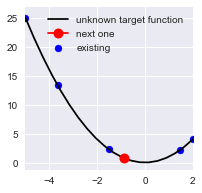


-----------------------------------------------



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:08<00:00, 177.04it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


grad: [-4.0308902e-06]
x_next: [-0.42055044]


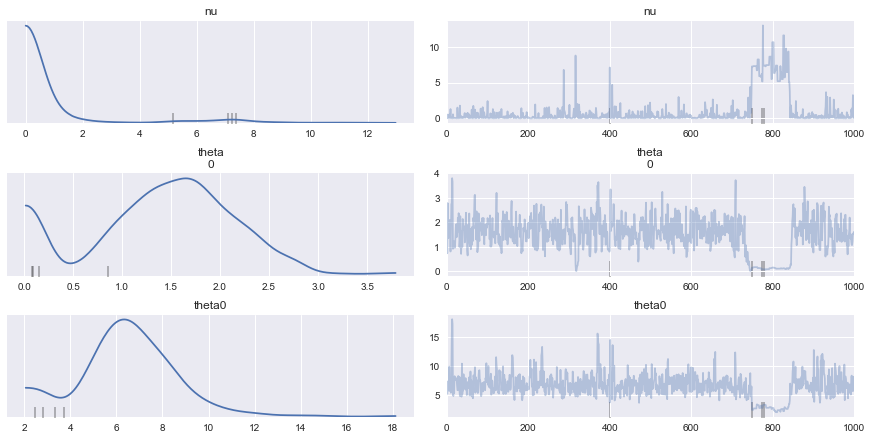

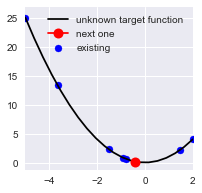

grad: [-1.38777878e-08]
x_next: [-0.30801654]


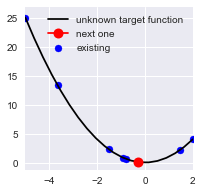

grad: [2.68712511e-19]
x_next: [-0.09973368]


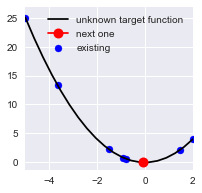

grad: [-1.86517468e-06]
x_next: [-1.49969991]


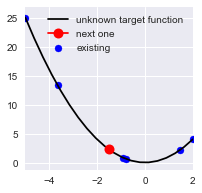


-----------------------------------------------



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:07<00:00, 206.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


grad: [3.52259231e-08]
x_next: [-0.11359831]


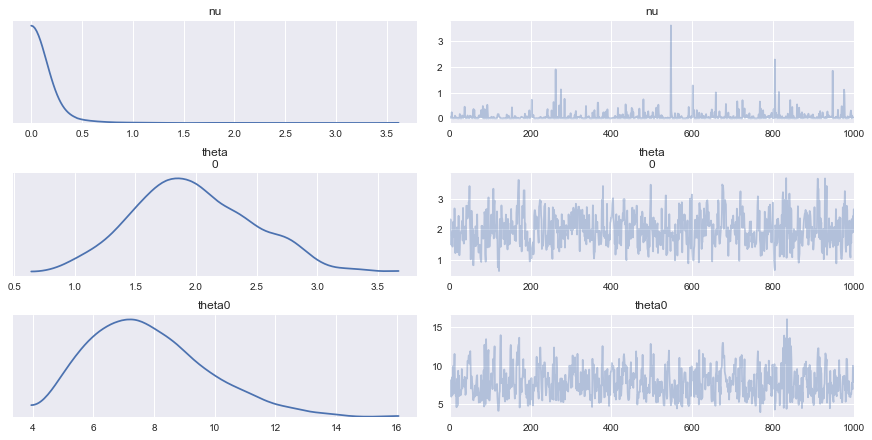

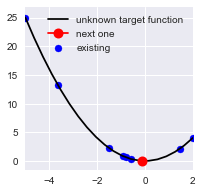

grad: [9.31380911e-18]
x_next: [-0.02107657]


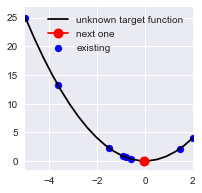

grad: [2.70095492e-06]
x_next: [-0.11814044]


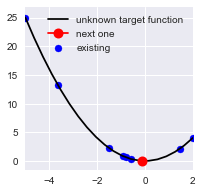

grad: [1.13695945e-06]
x_next: [-0.34513917]


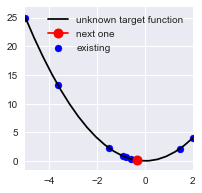


-----------------------------------------------



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:07<00:00, 202.16it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


grad: [6.0182306e-24]
x_next: [-0.04210637]


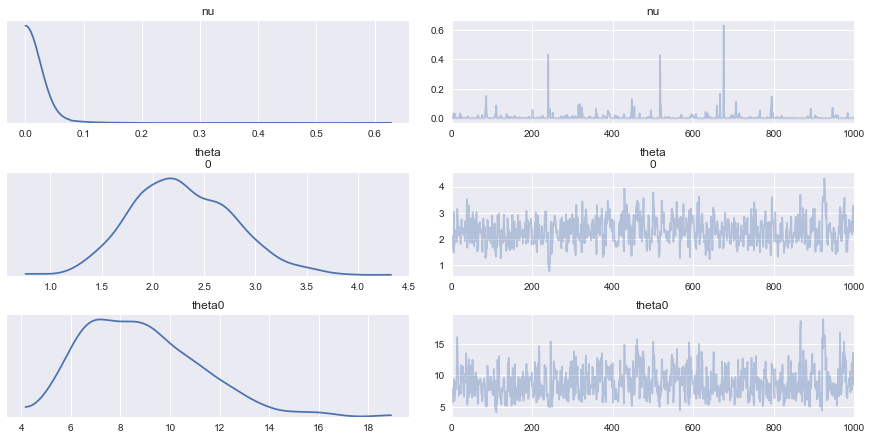

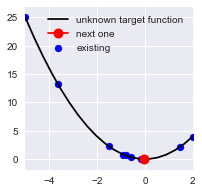

grad: [3.3394231e-33]
x_next: [-0.02841467]


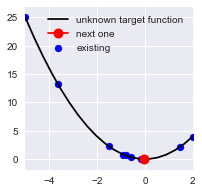

grad: [-5.0037116e-70]
x_next: [-0.00123449]


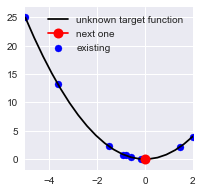

grad: [2.8018356e-10]
x_next: [-0.02061556]


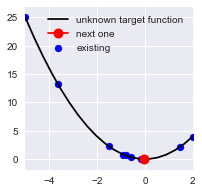


-----------------------------------------------



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:07<00:00, 195.01it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


grad: [0.00099623]
x_next: [-0.00173577]


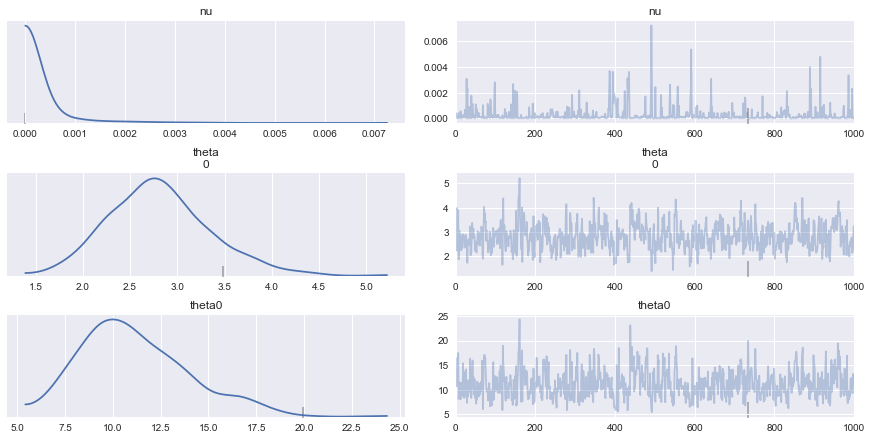

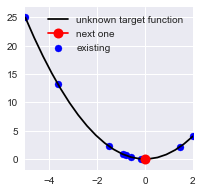

grad: [-0.00016494]
x_next: [-0.00269047]


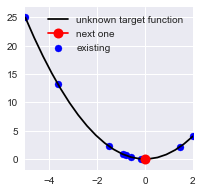

grad: [0.00059615]
x_next: [-0.00146323]


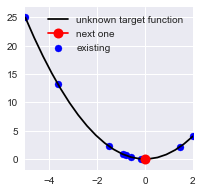

grad: [0.00015316]
x_next: [-0.001982]


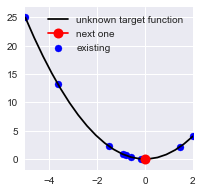


-----------------------------------------------



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [11:21<00:00,  1.79it/s]
The acceptance probability does not match the target. It is 1.0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/ysgc/anaconda3/envs/my35/lib/python3.5/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


grad: [0.00039087]
x_next: [-0.00212669]


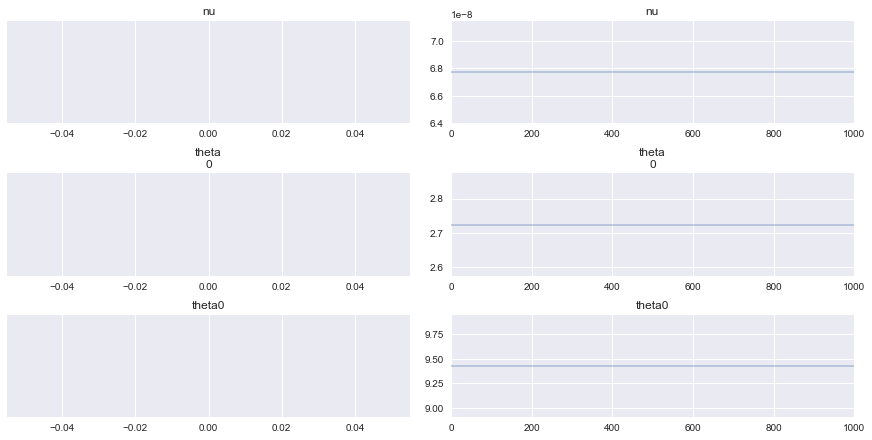

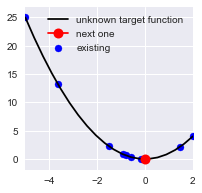

grad: [-0.00050127]
x_next: [-0.00212669]


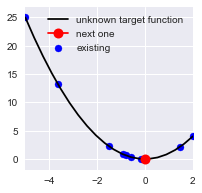

grad: [0.00035137]
x_next: [-0.00130583]


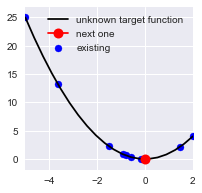

grad: [0.00015569]
x_next: [-0.00130583]


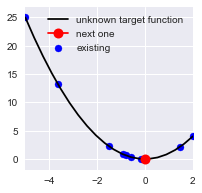




-----------------------------------------------



best result is  [-0.00171626]


In [11]:
baye_1d_GP_MCMC_EI = BayeOpt(target_func=g,x_range=g_range,init_points=6)
best_result = baye_1d_GP_MCMC_EI.Iteration(mode = "MCMC",acquisition = "EI",max_iter = 7)
print("\n\n\n-----------------------------------------------\n\n\n")
print("best result is ",best_result)

In the plot, the first 6 points along the iterations are actually initial points. The plots manifest the efficiency in training, as it only takes three to four real iterations to find a fairly small value of the target function.

Text(0.5, 1.0, 'Optimization of target function over iterations')

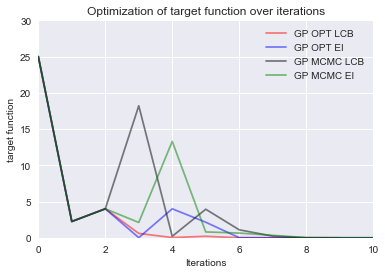

In [12]:
plt.xlim(0,10)
plt.ylim(0,30)
plt.xlabel("Iterations",fontsize=10)
plt.ylabel("target function",fontsize=10)
plt.plot(baye_1d_GP_OPT_LCB.y,c="r",alpha = 0.5)
plt.plot(baye_1d_GP_OPT_EI.y,c="b",alpha = 0.5)
plt.plot(baye_1d_GP_MCMC_LCB.y,c="k",alpha = 0.5)
plt.plot(baye_1d_GP_MCMC_EI.y,c="g", alpha = 0.5)
plt.legend(['GP OPT LCB','GP OPT EI','GP MCMC LCB','GP MCMC EI'])
plt.title('Optimization of target function over iterations')

---
From 1D example, we found tuning parameters by using GP OPT LCB is the most efficient.

---

## Practical Application! 
## MNIST with Neural Network Model

After verifying the viability and robustness of our model for Bayesian Optimization of hyperparameters, we decided to apply the algorithm on the classic machine learning training set - `MNIST`. 

Below we apply Bayesian optimization to tune the hyperparameters of the neural network. Specifically, for the 1D case we tuned the **learning rate** and for the 2D case we tuned the **learning rate** and the **regularization** terms.

In [30]:
# Adapted from pytorch's official example code: https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return -100. * correct / len(test_loader.dataset) # minus accuracy for minization

In [31]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=256, shuffle=True)

In [32]:
def f(LR):
    model = Net()
    optimizer = optim.Adam(model.parameters(),lr=10**float(LR))
    for epoch in range(10):
        train(model, train_loader, optimizer)
    return test(model, test_loader)


f_range = [-5, 2]

In [33]:
baye_1d = BayeOpt(target_func=f,x_range=f_range,init_points=4,render=False)

[[-5.       ]
 [-1.5      ]
 [ 2.       ]
 [-3.5428539]]


In [35]:
baye_1d.Iteration(mode="OPT",acquisition ="LCB",max_iter=7)


-----------------------------------------------




  0%|          | 0/5000 [00:00<?, ?it/s]
logp = -1,794.2, ||grad|| = 2,523.3:   0%|          | 0/5000 [00:00<?, ?it/s]
logp = -47.461, ||grad|| = 2.5981:   0%|          | 10/5000 [00:00<00:10, 457.18it/s]
logp = -45.235, ||grad|| = 0.030672:   0%|          | 20/5000 [00:00<00:09, 503.32it/s]
logp = -45.21, ||grad|| = 0.00033587:   1%|          | 30/5000 [00:00<00:09, 544.35it/s]
logp = -45.21, ||grad|| = 0.00033587: 100%|██████████| 36/36 [00:00<00:00, 560.58it/s]  

grad: [0.]
x_next: [-1.49522922]

-----------------------------------------------




  0%|          | 0/5000 [00:00<?, ?it/s]
logp = -1,919, ||grad|| = 2,719.9:   0%|          | 0/5000 [00:00<?, ?it/s]
logp = -47.901, ||grad|| = 5.9582:   0%|          | 10/5000 [00:00<00:08, 577.16it/s]
logp = -43.754, ||grad|| = 0.046179:   0%|          | 20/5000 [00:00<00:08, 615.86it/s]
logp = -43.75, ||grad|| = 0.0026737:   1%|          | 30/5000 [00:00<00:07, 625.46it/s]
logp = -43.75, ||grad|| = 0.0026737: 100%|██████████| 38/38 [00:00<00:00, 638.68it/s]  

grad: [3.41060513e-05]
x_next: [-4.21405436]

-----------------------------------------------




  0%|          | 0/5000 [00:00<?, ?it/s]
logp = -2,053.5, ||grad|| = 2,965.8:   0%|          | 0/5000 [00:00<?, ?it/s]
logp = -50.812, ||grad|| = 5.3057:   0%|          | 10/5000 [00:00<00:09, 537.70it/s]
logp = -47.182, ||grad|| = 0.076888:   0%|          | 20/5000 [00:00<00:08, 605.35it/s]
logp = -47.179, ||grad|| = 0.001143:   1%|          | 30/5000 [00:00<00:08, 603.19it/s]
logp = -47.179, ||grad|| = 0.001143: 100%|██████████| 41/41 [00:00<00:00, 624.73it/s]  

grad: [3.55271368e-05]
x_next: [-4.5750324]

-----------------------------------------------




  0%|          | 0/5000 [00:00<?, ?it/s]
logp = -2,190.3, ||grad|| = 3,175.6:   0%|          | 0/5000 [00:00<?, ?it/s]
logp = -52.872, ||grad|| = 6.1479:   0%|          | 10/5000 [00:00<00:08, 620.23it/s]
logp = -49.164, ||grad|| = 0.044061:   0%|          | 20/5000 [00:00<00:07, 645.22it/s]
logp = -49.16, ||grad|| = 0.01174:   1%|          | 30/5000 [00:00<00:07, 667.71it/s]  
logp = -49.16, ||grad|| = 0.01174: 100%|██████████| 41/41 [00:00<00:00, 699.42it/s]  

grad: [7.67386155e-05]
x_next: [-3.77571961]

-----------------------------------------------




  0%|          | 0/5000 [00:00<?, ?it/s]
logp = -2,355.5, ||grad|| = 3,419.8:   0%|          | 0/5000 [00:00<?, ?it/s]
logp = -54.978, ||grad|| = 7.0656:   0%|          | 10/5000 [00:00<00:09, 519.84it/s]
logp = -51.514, ||grad|| = 0.025502:   0%|          | 20/5000 [00:00<00:09, 547.96it/s]
logp = -51.507, ||grad|| = 0.01504:   1%|          | 30/5000 [00:00<00:09, 541.30it/s] 
logp = -51.507, ||grad|| = 0.01504: 100%|██████████| 40/40 [00:00<00:00, 569.70it/s]  

grad: [0.00091518]
x_next: [-3.62748472]

-----------------------------------------------




  0%|          | 0/5000 [00:00<?, ?it/s]
logp = -2,515.1, ||grad|| = 3,648.1:   0%|          | 0/5000 [00:00<?, ?it/s]
logp = -56.433, ||grad|| = 9.2791:   0%|          | 10/5000 [00:00<00:08, 594.71it/s]
logp = -49.714, ||grad|| = 0.26277:   0%|          | 20/5000 [00:00<00:07, 660.81it/s]
logp = -49.711, ||grad|| = 0.013298:   1%|          | 30/5000 [00:00<00:07, 687.13it/s]
logp = -49.711, ||grad|| = 0.013298: 100%|██████████| 39/39 [00:00<00:00, 725.84it/s]  

grad: [-0.04433502]
x_next: [-3.60597942]

-----------------------------------------------




  0%|          | 0/5000 [00:00<?, ?it/s]
logp = -2,655.2, ||grad|| = 3,845.6:   0%|          | 0/5000 [00:00<?, ?it/s]
logp = -57.617, ||grad|| = 11.627:   0%|          | 10/5000 [00:00<00:08, 603.71it/s]
logp = -48.026, ||grad|| = 0.14973:   0%|          | 20/5000 [00:00<00:06, 720.49it/s]
logp = -48.026, ||grad|| = 0.14973: 100%|██████████| 26/26 [00:00<00:00, 764.98it/s]  

grad: [-0.0057895]
x_next: [-3.61980012]


array([-3.60597942])

From the above cell we can see that for GP OPT LCB, the optimal learning rate is  $10^{-3.60597942}\approx 0.00025$. 